In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import os
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
import numpy as np

In C:\Users\zorta\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\zorta\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\zorta\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\zorta\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\zorta\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mpl

In [2]:
batch_size = 32
img_height = 128
img_width = 128

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "../data/hurricane_images",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=(img_height, img_width),
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "../data/hurricane_images",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=(img_height, img_width),
    batch_size=batch_size,
)


Found 10001 files belonging to 2 classes.
Using 8001 files for training.
Found 10001 files belonging to 2 classes.
Using 2000 files for validation.


In [3]:
class_names = train_ds.class_names
print(class_names)

['damage', 'no_damage']


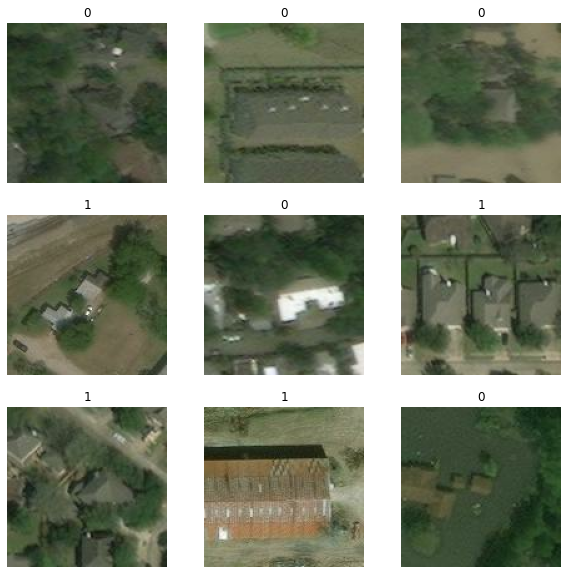

In [4]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [5]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break


(32, 128, 128, 3)
(32,)


In [6]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [7]:

data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
                                                                                                                        
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

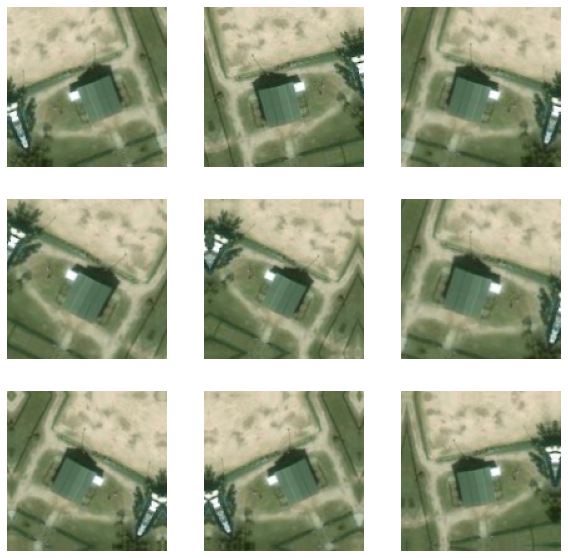

In [8]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [9]:

def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=(img_height,img_width ) + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [10]:
epochs = 15

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)

Epoch 1/15
251/251 [==============================] - 1078s 4s/step - loss: 0.3353 - accuracy: 0.8619 - val_loss: 2.1918 - val_accuracy: 0.4985
Epoch 2/15
251/251 [==============================] - 1263s 5s/step - loss: 0.1763 - accuracy: 0.9285 - val_loss: 3.4225 - val_accuracy: 0.4985
Epoch 3/15
251/251 [==============================] - 1562s 6s/step - loss: 0.1475 - accuracy: 0.9412 - val_loss: 0.8040 - val_accuracy: 0.5850
Epoch 4/15
251/251 [==============================] - 1285s 5s/step - loss: 0.1393 - accuracy: 0.9466 - val_loss: 1.4344 - val_accuracy: 0.6350
Epoch 5/15
251/251 [==============================] - 1418s 6s/step - loss: 0.1306 - accuracy: 0.9533 - val_loss: 1.7851 - val_accuracy: 0.5320
Epoch 6/15
251/251 [==============================] - 1168s 5s/step - loss: 0.1093 - accuracy: 0.9584 - val_loss: 0.2005 - val_accuracy: 0.9205
Epoch 7/15
251/251 [==============================] - 1090s 4s/step - loss: 0.1013 - accuracy: 0.9611 - val_loss: 0.4707 - val_accuracy:

In [34]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_7 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_4 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 45, 45, 64)       

In [11]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
250/250 [==============================] - 117s 467ms/step - loss: 0.6717 - accuracy: 0.5514 - val_loss: 0.3567 - val_accuracy: 0.8555
Epoch 2/15
250/250 [==============================] - 117s 469ms/step - loss: 0.3096 - accuracy: 0.8683 - val_loss: 0.2261 - val_accuracy: 0.9090
Epoch 3/15
250/250 [==============================] - 114s 458ms/step - loss: 0.2154 - accuracy: 0.9109 - val_loss: 0.2495 - val_accuracy: 0.9020
Epoch 4/15
250/250 [==============================] - 115s 459ms/step - loss: 0.2075 - accuracy: 0.9160 - val_loss: 0.1766 - val_accuracy: 0.9260
Epoch 5/15
250/250 [==============================] - 118s 473ms/step - loss: 0.1765 - accuracy: 0.9283 - val_loss: 0.2238 - val_accuracy: 0.9165
Epoch 6/15
250/250 [==============================] - 123s 491ms/step - loss: 0.1560 - accuracy: 0.9370 - val_loss: 0.1604 - val_accuracy: 0.9350
Epoch 7/15
250/250 [==============================] - 120s 481ms/step - loss: 0.1601 - accuracy: 0.9363 - val_loss: 0.1986 -

In [18]:
img = keras.preprocessing.image.load_img(
    "../data/test6.jpeg", target_size=(img_height,img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = predictions[0]
print(
    "This image is %.2f percent damage and %.2f percent no damage."
    % (100 * (1 - score), 100 * score)
)

This image is 99.95 percent damage and 0.05 percent no damage.


In [15]:
model.save('../model/harvey_model3.h5')

In [33]:
model.evaluate(val_ds)

63/63 [==============================] - 12s 192ms/step - loss: 0.1024 - accuracy: 0.9655


[0.10242053866386414, 0.965499997138977]